In [2]:
%%html
<style>
/* Any CSS style can go in here. */
.dataframe th {
    font-size: 18px;
}
.dataframe td {
    font-size: 16px;
}
</style>

# ProbAI simulator

## TODO

### Misc
* Transformation of non-observed columns? E.g., actions at time 2

### Actions
* Let enrolment depend on age, education and previous income
* Let effect alter probability of getting married, switching jobs, etc + actual income
* Have at least 3 kinds of actions, maybe "no action", "evening course", "daytime course"

In [3]:
%load_ext autoreload
%autoreload 2

import sys, time
import pandas as pd
import numpy as np
import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from inspect import isclass
from argparse import Namespace
import warnings
from sklearn.exceptions import ConvergenceWarning

sys.path.append('../')

from income.data import *
from income.util import *
from income.samplers import *
from income.income_samplers import *
from income.arm import *
from income.income import *

In [4]:
# Load data
D_tr, c_cat, c_num, c_out, c_features, educ_map = load_income_data('../data/income')

In [5]:
D_tr

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income>50k,capital-net,id,time,training,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,0,2174,0,0,No training,0
1,50,Self-emp-not-inc,Bachelors,13,Married,Exec-managerial,Husband,White,Male,13,United-States,0,0,1,0,Evening course,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,0,0,2,0,Day course,0
3,53,Private,11th,7,Married,Handlers-cleaners,Husband,Black,Male,40,United-States,0,0,3,0,Full-time studies,0
4,28,Private,Bachelors,13,Married,Prof-specialty,Wife,Black,Female,40,Cuba,0,0,4,0,No training,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married,Tech-support,Wife,White,Female,38,United-States,0,0,30157,0,Evening course,0
32557,40,Private,HS-grad,9,Married,Machine-op-inspct,Husband,White,Male,40,United-States,1,0,30158,0,Day course,1
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,40,United-States,0,0,30159,0,Full-time studies,0
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,20,United-States,0,0,30160,0,No training,0


In [7]:
# Fit transformation
T = SubsetTransformer()
D_prev = D_tr.copy().rename(columns=dict([(c,c+'#prev') for c in D_tr.columns if not c == 'id']))
D_tran = pd.merge(D_tr, D_prev, on='id')

# Ensures that we avoid transforming income#prev
D_tran['income#prev'] = np.random.randn(D_tran.shape[0])

T.fit(D_tran)
T.transform(D_tran)

,age,education-num,hours-per-week,income>50k,capital-net,id,time,income,age#prev,education-num#prev,...,native-country#prev_Taiwan,native-country#prev_Thailand,native-country#prev_Trinadad&Tobago,native-country#prev_United-States,native-country#prev_Vietnam,native-country#prev_Yugoslavia,training#prev_Day course,training#prev_Evening course,training#prev_Full-time studies,training#prev_No training
0,0.042796,1.128918,-0.077734,-0.575691,0.157514,-1.731993,0.0,-0.575691,0.042796,1.128918,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.880288,1.128918,-2.331531,-0.575691,-0.135074,-1.731879,0.0,-0.575691,0.880288,1.128918,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.033340,-0.439738,-0.077734,-0.575691,-0.135074,-1.731764,0.0,-0.575691,-0.033340,-0.439738,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.108695,-1.224066,-0.077734,-0.575691,-0.135074,-1.731649,0.0,-0.575691,1.108695,-1.224066,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.794697,1.128918,-0.077734,-0.575691,-0.135074,-1.731534,0.0,-0.575691,-0.794697,1.128918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,-0.870832,0.736754,-0.244682,-0.575691,-0.135074,1.731534,0.0,-0.575691,-0.870832,0.736754,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
30158,0.118931,-0.439738,-0.077734,1.737042,-0.135074,1.731649,0.0,1.737042,0.118931,-0.439738,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
30159,1.489374,-0.439738,-0.077734,-0.575691,-0.135074,1.731764,0.0,-0.575691,1.489374,-0.439738,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
30160,-1.251511,-0.439738,-1.747213,-0.575691,-0.135074,1.731879,0.0,-0.575691,-1.251511,-0.439738,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
# Create ARM model
A = init_income_ARM(T, educ_map)

# Fit to observed data 
warnings.filterwarnings("ignore", category=ConvergenceWarning)
A.fit(D_tr)

In [9]:
# Sample observations
m = 1000
horizon = 5
seed = 0
version = 3

np.random.seed(seed)
S = A.sample(m, T=horizon)

In [10]:
S.to_pickle('../data/income_v%d_m%d_T%d_s%d.pkl' % (version, m, horizon, seed))

In [173]:
# Define enfironments with target policies

A_target1 = A.copy()
A_target1.replace_variable('training', [], TrainingSamplerPolicy1(), seq_sampler=TrainingTransitionPolicy1(), 
                   seq_parents_curr=['age', 'education-num'], seq_parents_prev=['income'], 
                   seq_transform_input=False)

A_target2 = A.copy()
A_target2.replace_variable('training', ['age', 'education-num'], TrainingSamplerPolicy2(), seq_sampler=TrainingTransitionPolicy2(), 
                   seq_parents_curr=['age', 'education-num'], seq_parents_prev=['income'], 
                   seq_transform_input=False)

A_target3 = A.copy()
A_target3.replace_variable('training', [], TrainingSamplerPolicy1())

A_targetStartNo = A.copy()
A_targetStartNo.replace_variable('training', [], ConstantSampler('No training'), seq_sampler=TrainingTransition(TrainingSampler()), 
                   seq_parents_curr=['age', 'sex', 'education', 'education-num', 'relationship', 'time'], seq_parents_prev=['training','income'], 
                   seq_transform_input=False)

A_targetStartFull = A.copy()
A_targetStartFull.replace_variable('training', [], ConstantSampler('Full-time studies'), seq_sampler=TrainingTransition(TrainingSampler()), 
                   seq_parents_curr=['age', 'sex', 'education', 'education-num', 'relationship', 'time'], seq_parents_prev=['training','income'], 
                   seq_transform_input=False)


# Sample observations under target policy 1
np.random.seed(seed)
S1 = A_target1.sample(m, T=horizon)

# Sample observations under target policy 2
np.random.seed(seed)
S2 = A_target2.sample(m, T=horizon)

# Sample observations under target policy 3
np.random.seed(seed)
S3 = A_target3.sample(m, T=horizon)

# Sample observations under target policy Start No
np.random.seed(seed)
SStartNo = A_targetStartNo.sample(m, T=horizon)

# Sample observations under target policy Start No
np.random.seed(seed)
SStartFull = A_targetStartFull.sample(m, T=horizon)


In [174]:
Ss = pd.read_pickle('Income_v%d_m%d_T%d_s%d.pkl' % (version, m, horizon, seed))

In [175]:
#print('Average cumulative income (Behavior saved):', Ss.groupby('id').sum()['income'].mean())
#print('Average cumulative income (Behavior):', S.groupby('id').sum()['income'].mean())
#print('Average cumulative income (Target 1):', S1.groupby('id').sum()['income'].mean())
#print('Average cumulative income (Target 2):', S2.groupby('id').sum()['income'].mean())
#print('Average cumulative income (Target 3):', S3.groupby('id').sum()['income'].mean())

Tend = 9
print('Average income (Start No Training):', SStartNo[SStartNo['time']==Tend].groupby('id').sum()['income'].mean())
print('Average income (Start Full-time studies):', SStartFull[SStartFull['time']==Tend].groupby('id').sum()['income'].mean())

ids_in_age_range = SStartNo[(SStartNo['time']==0) & (SStartNo['age']>=20) & (SStartNo['age']<=55)]['id'].unique()


print('Average income (Start No Training):', SStartNo[(SStartNo['time']==Tend)&(SStartNo['id'].isin(ids_in_age_range))].groupby('id').sum()['income'].mean())
print('Average income (Start Full-time studies):', SStartFull[(SStartFull['time']==Tend)&(SStartFull['id'].isin(ids_in_age_range))].groupby('id').sum()['income'].mean())

print(SStartNo['id'].unique())
print(ids_in_age_range)

print('Average cumulative income (Start No Training):', SStartNo.groupby('id').sum()['income'].mean())
print('Average cumulative income (Start Full-time studies):', SStartFull.groupby('id').sum()['income'].mean())

# Group ??? (IPW)
# 770k
# 634k

# Group Causal Casualties / Fancy socks (Model-based)
#
#


print('Income after t years')
for t in range(1,11):
    print(t)
    #print('Average cumulative income (Behavior):', S[S['time']<t].groupby('id').sum()['income'].mean())
    #print('Average cumulative income (Target 1):', S1[S1['time']<t].groupby('id').sum()['income'].mean())
    #print('Average cumulative income (Target 2):', S2[S2['time']<t].groupby('id').sum()['income'].mean())
    #print('Average cumulative income (Target 3):', S3[S3['time']<t].groupby('id').sum()['income'].mean())
    print('Average cumulative income (Start No Training):', SStartNo[SStartNo['time']<t].groupby('id').sum()['income'].mean())
    print('Average cumulative income (Start Full-time studies):', SStartFull[SStartNo['time']<t].groupby('id').sum()['income'].mean())

Average income (Start No Training): nan
Average income (Start Full-time studies): nan
Average income (Start No Training): nan
Average income (Start Full-time studies): nan
[    0     1     2 ... 49997 49998 49999]
[    0     1     2 ... 49997 49998 49999]
Average cumulative income (Start No Training): 434090.97334
Average cumulative income (Start Full-time studies): 507391.80148
Income after t years
1
Average cumulative income (Start No Training): 74342.33036
Average cumulative income (Start Full-time studies): 0.0
2
Average cumulative income (Start No Training): 153608.12558
Average cumulative income (Start Full-time studies): 100887.23066
3
Average cumulative income (Start No Training): 239929.55662
Average cumulative income (Start Full-time studies): 224979.85214
4
Average cumulative income (Start No Training): 333408.95134
Average cumulative income (Start Full-time studies): 362480.11618
5
Average cumulative income (Start No Training): 434090.97334
Average cumulative income (Start 

,0,100,200,300,400,500,600,700,800,900
id,0,0,0,0,0,0,0,0,0,0
time,0,1,2,3,4,5,6,7,8,9
native-country,United-States,United-States,United-States,United-States,United-States,United-States,United-States,United-States,United-States,United-States
sex,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
race,White,White,White,White,White,White,White,White,White,White
age,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0
education,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad,HS-grad
training,No Training,No Training,Evening course,Evening course,No Training,Evening course,Evening course,No Training,No Training,No Training
workclass,Self-emp-not-inc,Self-emp-not-inc,Self-emp-not-inc,Self-emp-not-inc,Self-emp-not-inc,Self-emp-not-inc,Self-emp-not-inc,Self-emp-not-inc,Self-emp-not-inc,Self-emp-not-inc
occupation,Adm-clerical,Transport-moving,Transport-moving,Transport-moving,Transport-moving,Craft-repair,Craft-repair,Craft-repair,Farming-fishing,Farming-fishing


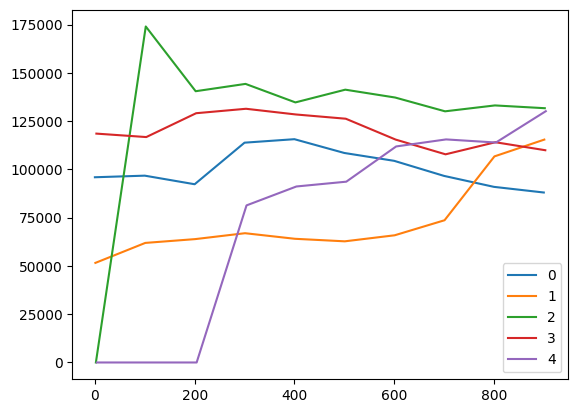

In [28]:
display(S[S['id']==0].T)

for i in range(5):
    plt.plot(S[S['id']==i]['income'], label='%d' % i)
plt.legend()

# Hours per week vs. Age

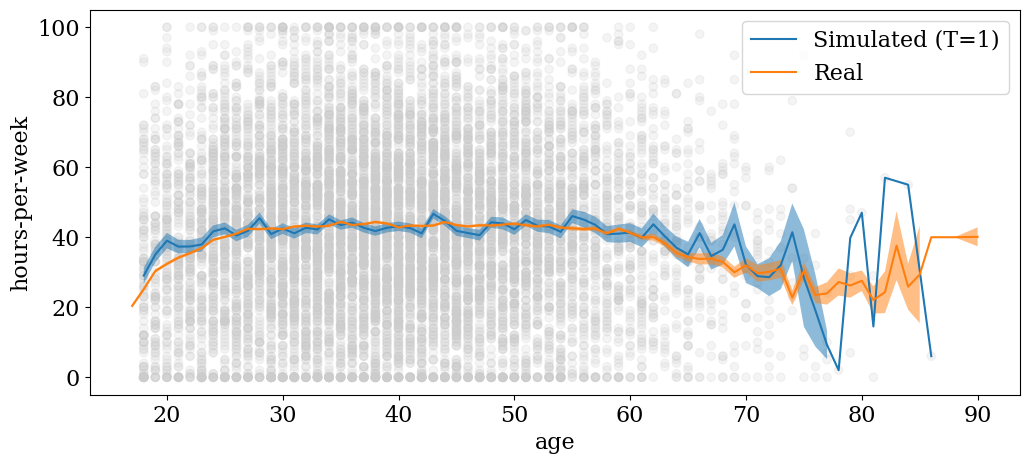

# Simulated income

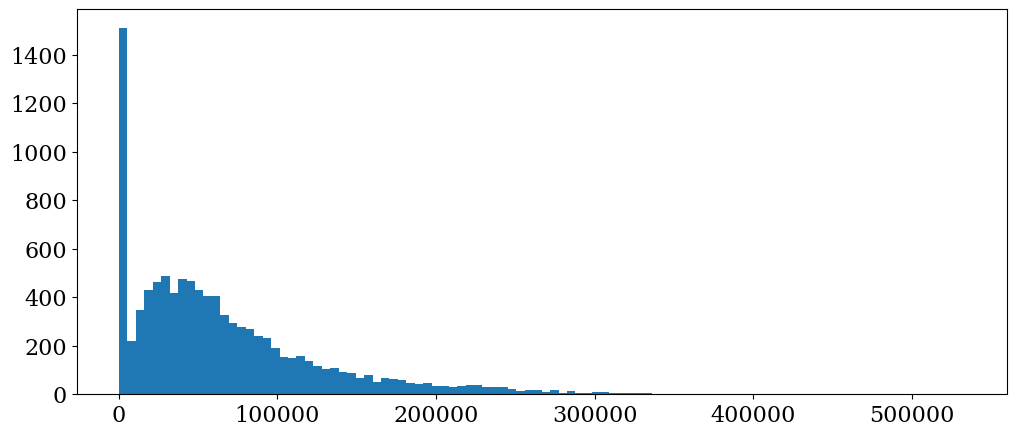

# Income vs. Hours per week

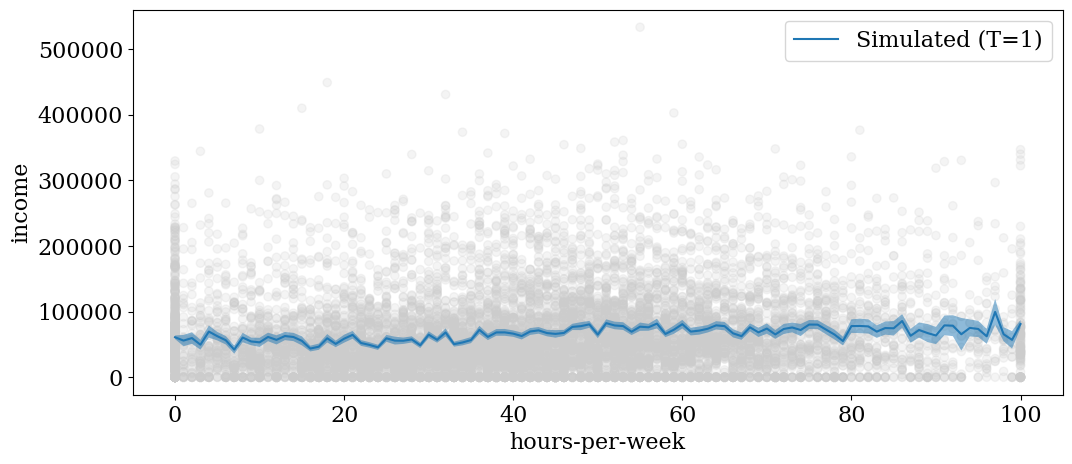

# Income vs. Age

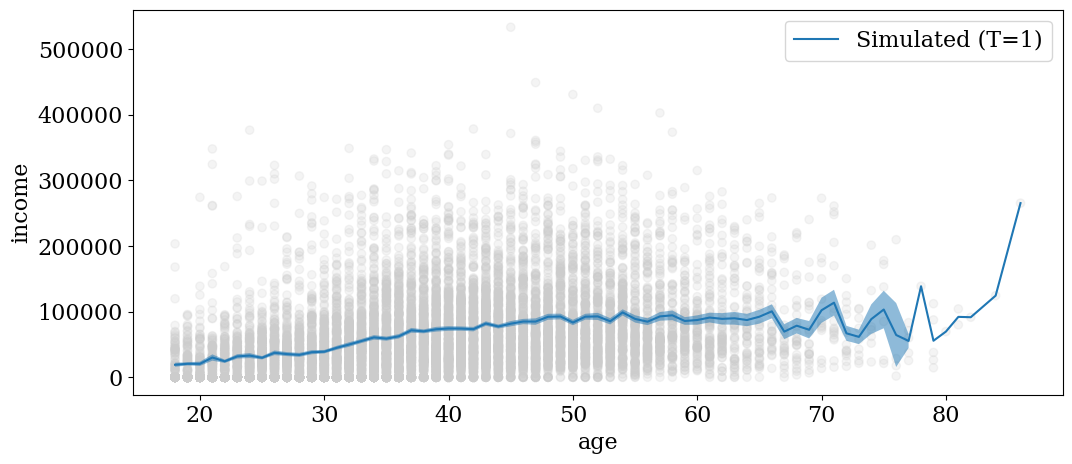

# Income vs. race

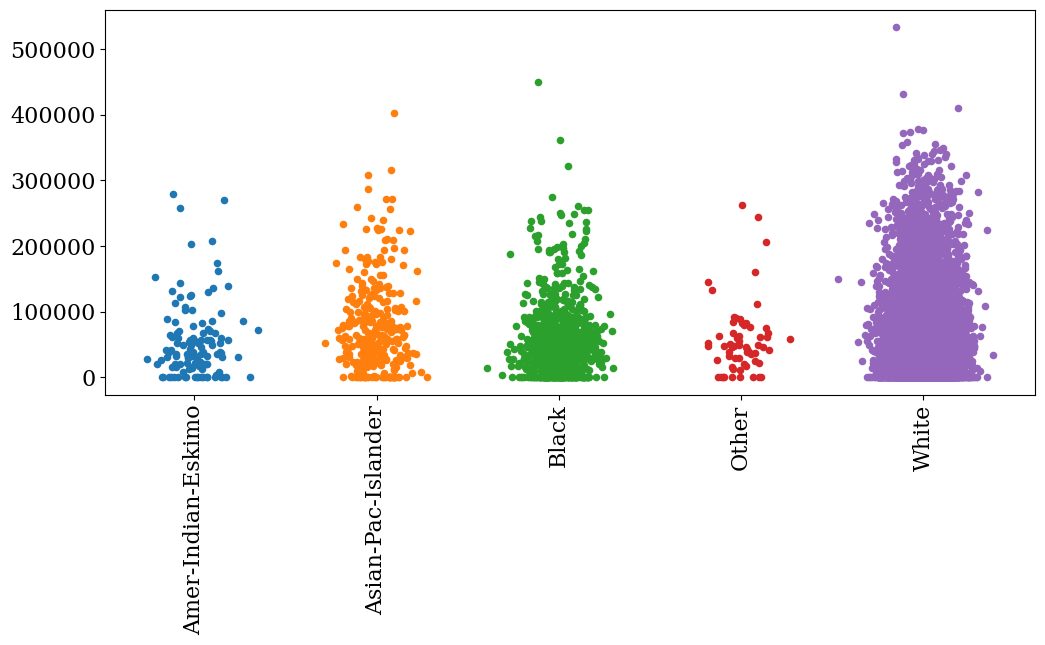

# Income vs. sex

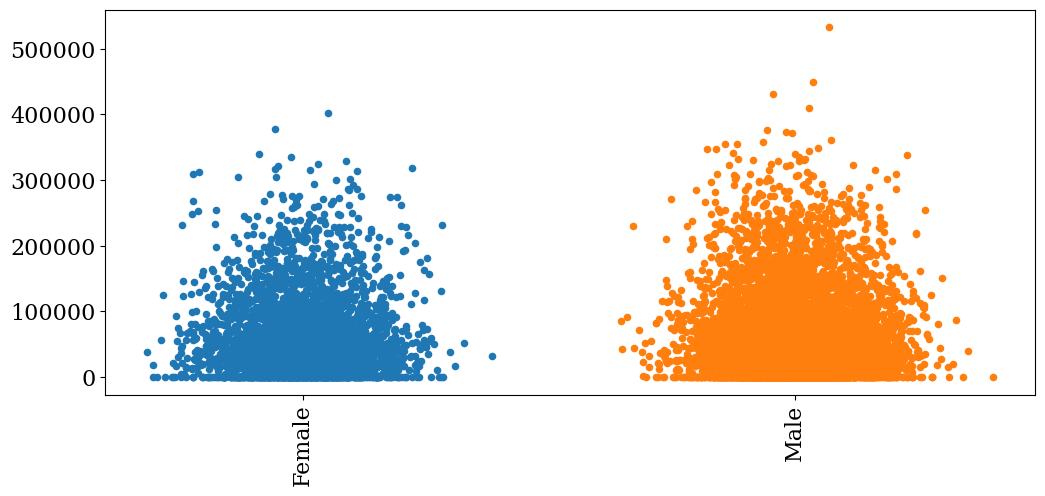

# Capital net

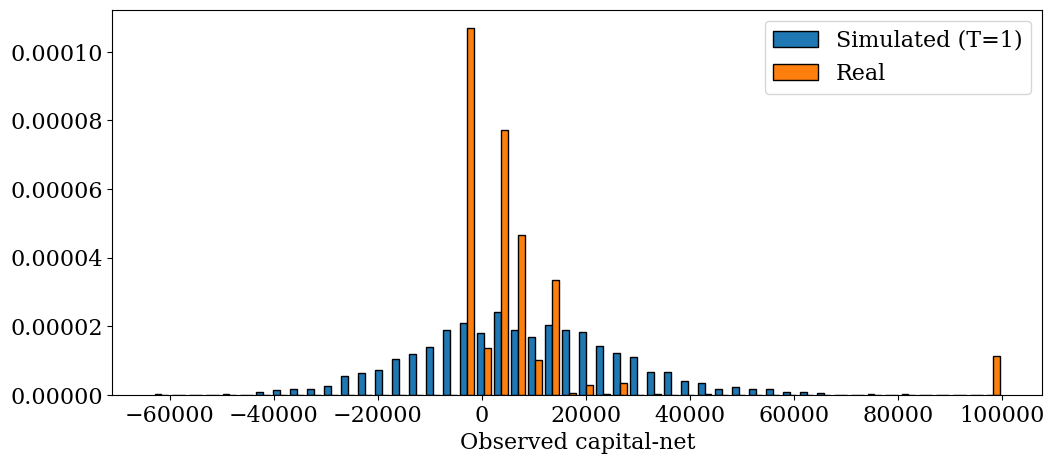

# Capital net vs. Income

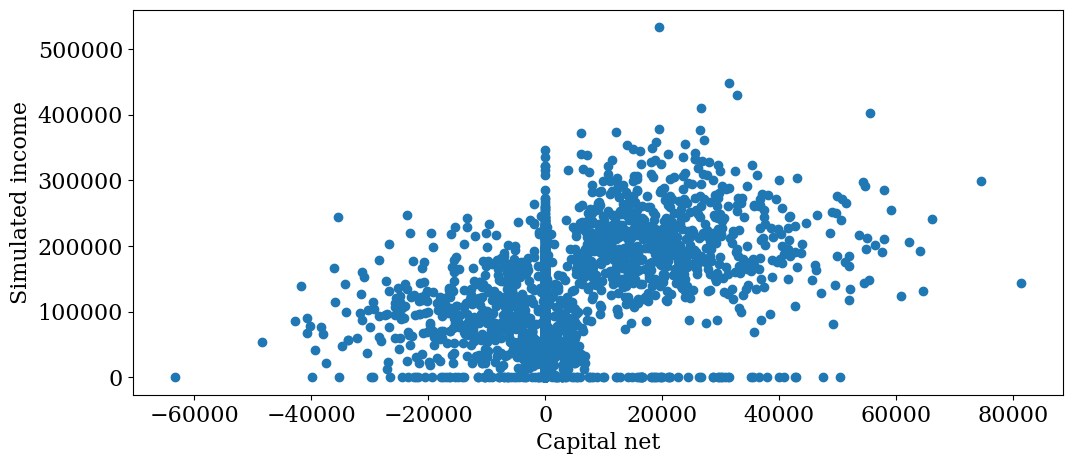

# Training vs Age

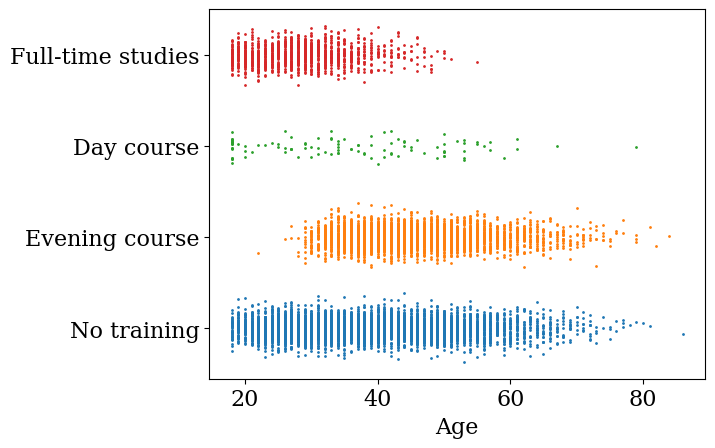

# Marital status vs Time

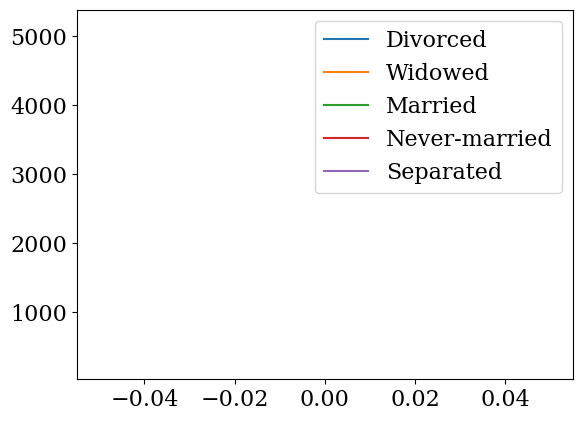

In [150]:
plt.rc('font', size=16, family='serif')

"""

HOURS PER WEEK VS AGE

"""
display(Markdown('# Hours per week vs. Age'))
x_col = 'age'
y_col = 'hours-per-week'
Sgr = S[[x_col, y_col]].groupby(x_col, as_index=False)
x = Sgr.mean()[x_col]; y = Sgr.mean()[y_col]
s = Sgr.std()[y_col]; c = Sgr.count()[y_col]

plt.figure(figsize=(12,5))
plt.fill_between(x,y-s/np.sqrt(c), y+s/np.sqrt(c), alpha=0.5)
plt.plot(x, y, label='Simulated (T=%d)' % horizon)

Sgr = D_tr[[x_col, y_col]].groupby(x_col, as_index=False)
x = Sgr.mean()[x_col]; y = Sgr.mean()[y_col]
s = Sgr.std()[y_col]; c = Sgr.count()[y_col]

plt.fill_between(x,y-s/np.sqrt(c), y+s/np.sqrt(c), alpha=0.5)
plt.plot(x, y, label='Real')
plt.scatter(S[x_col], S[y_col], zorder=-100, c=[[0.8,0.8,0.8]]*S.shape[0], alpha=0.2)

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.legend()
plt.show()

"""

Income

"""
display(Markdown('# Simulated income'))
plt.figure(figsize=(12,5))
plt.hist(S['income'], bins=100)
plt.show()


"""

INCOME VS HOURS PER WEEK

"""
display(Markdown('# Income vs. Hours per week'))
x_col = 'hours-per-week'
y_col = 'income'
Sgr = S[[x_col, y_col]].groupby(x_col, as_index=False)
x = Sgr.mean()[x_col]; y = Sgr.mean()[y_col]
s = Sgr.std()[y_col]; c = Sgr.count()[y_col]

plt.figure(figsize=(12,5))
plt.fill_between(x,y-s/np.sqrt(c), y+s/np.sqrt(c), alpha=0.5)
plt.plot(x, y, label='Simulated (T=%d)' % horizon)
plt.scatter(S[x_col], S[y_col], zorder=-100, c=[[0.8,0.8,0.8]]*S.shape[0], alpha=0.2)

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.legend()
plt.show()

"""

INCOME VS AGE

"""
display(Markdown('# Income vs. Age'))
x_col = 'age'
y_col = 'income'
Sgr = S[[x_col, y_col]].groupby(x_col, as_index=False)
x = Sgr.mean()[x_col]; y = Sgr.mean()[y_col]
s = Sgr.std()[y_col]; c = Sgr.count()[y_col]

plt.figure(figsize=(12,5))
plt.fill_between(x,y-s/np.sqrt(c), y+s/np.sqrt(c), alpha=0.5)
plt.plot(x, y, label='Simulated (T=%d)' % horizon)
plt.scatter(S[x_col], S[y_col], zorder=-100, c=[[0.8,0.8,0.8]]*S.shape[0], alpha=0.2)

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.legend()
plt.show()

"""

INCOME VS RACE

"""
plt.figure(figsize=(12,5))
display(Markdown('# Income vs. race'))
L = sorted(S['race'].unique())
for i in range(len(L)):
    x = S[S['race']==L[i]]
    plt.scatter(np.random.randn(x.shape[0])*0.1+i, x['income'], s=30, alpha=1, lw=0)
plt.xticks(range(len(L)), labels=L, rotation=90)
plt.show()



"""

INCOME VS SEX

"""
plt.figure(figsize=(12,5))
display(Markdown('# Income vs. sex'))
L = sorted(S['sex'].unique())
for i in range(len(L)):
    x = S[S['sex']==L[i]]
    plt.scatter(np.random.randn(x.shape[0])*0.1+i, x['income'], s=30, alpha=1, lw=0)
plt.xticks(range(len(L)), labels=L, rotation=90)
plt.show()



"""

Capital-net

"""
display(Markdown('# Capital net'))
plt.figure(figsize=(12,5))
plt.hist([S[S['capital-net'] != 0]['capital-net'], D_tr[D_tr['capital-net'] !=0]['capital-net']], 
         bins=50, ec='black', density=True, label=['Simulated (T=%d)' % horizon, 'Real'])
plt.xlabel('Observed capital-net')
plt.legend()
plt.show()

"""

Capital-net vs. Income

"""
display(Markdown('# Capital net vs. Income'))
plt.figure(figsize=(12,5))
plt.scatter(S['capital-net'], S['income'])
plt.xlabel('Capital net')
plt.ylabel('Simulated income')
plt.show()


"""

TRAINING

"""
display(Markdown('# Training vs Age'))
i = 0
for c in TrainingSampler.classes_:
    x = S[S['training']==c]['age']
    plt.scatter(x, np.random.randn(x.shape[0])*0.1+i, s=1)
    plt.yticks([0, 1, 2, 3], TrainingSampler.classes_)
    plt.xlabel('Age')
    i += 1
plt.show()
    
    
"""

TRAINING

"""
display(Markdown('# Marital status vs Time'))
i = 0
x_col = 'marital-status'
vs = S[x_col].unique()

x = S['time'].unique()
y = S.groupby(['marital-status', 'time'], as_index=False).count()
for c in vs:
    plt.plot(x, y[y['marital-status']==c]['id'], label=c)
    
plt.legend()
plt.show()

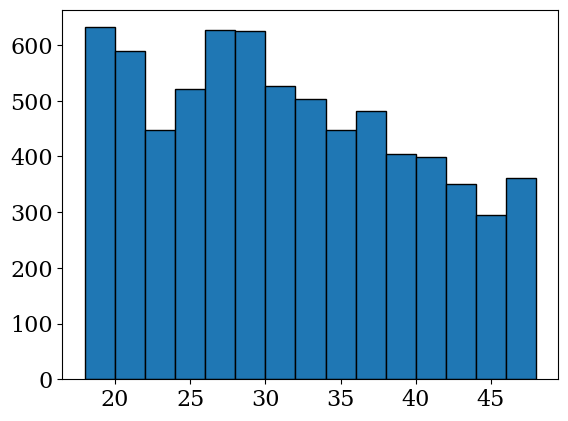

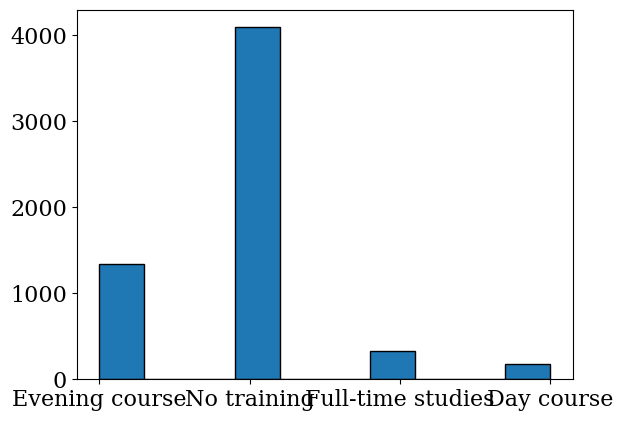

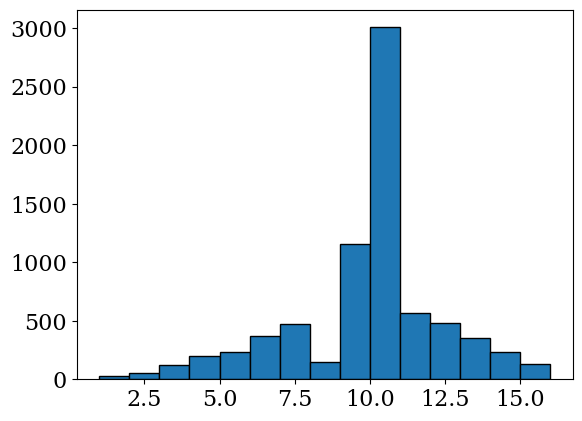

17 17


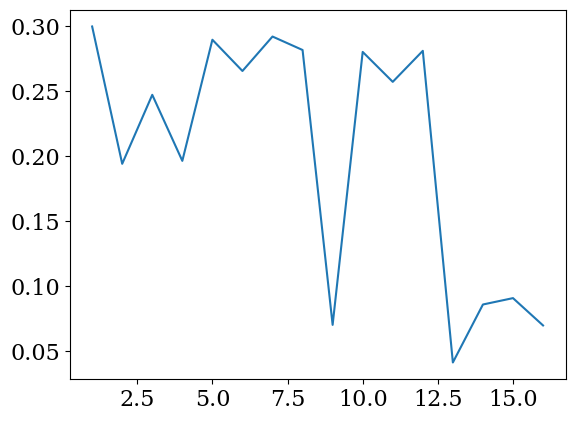

In [159]:
plt.hist(S[S['training']=='Full-time studies']['age'], bins=range(18,50,2), edgecolor='k')
plt.show()

plt.hist(S[S['relationship']=='Own-child']['training'], edgecolor='k')
plt.show()

plt.hist(S[S['training']=='Full-time studies']['education-num'], bins=range(1,17), edgecolor='k')
plt.show()

x = range(17)
y = [0]*17
for i in range(17):
    y[i] = (S[S['education-num']==i]['training']=='Full-time studies').mean()
print(len(x), len(y))
plt.plot(x,y)
